# Cross-sell Health Insurance Project

Feature|Description
--|--------------------------|
id|	Unique ID for the customer
Gender|	Gender of the customer
Age|	Age of the customer
Driving_License|	0 : Customer does not have DL, 1 : Customer already has DL
Region_Code|	Unique code for the region of the customer
Previously_Insured|	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
Vehicle_Age|	Age of the Vehicle
Vehicle_Damage|	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
Annual_Premium|	The amount customer needs to pay as premium in the year
PolicySalesChannel|	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
Vintage|	Number of Days, Customer has been associated with the company
Response|	1 : Customer is interested, 0 : Customer is not interested

## Insurance Business Model

An insurance business works like this: the insurance company assumes the risks of individual payers and redistributes it across a larger group of people.
There are, generally, two ways of generating revenues: charging premiums for insurance coverage and then reinvesting those premiums into interest-generating assets.
The premium is based on the risk of each customer. The company has to estimate the probability of a customer claiming the insurance and extend this risk till the end of the contract. The customers with the highest risks pay more, and the ones with the lowest risks pay less.

## Cross Selling Strategy

Cross-selling is a strategy for selling complementary products or related and complementary services, taking into account the customer's interest. In our case, we have a health insurance company that wants to sell vehicle insurance to its customers.

**Benefits**

Acquiring new customers is too expensive. So if we can sell other products to people that are already customers, we will spend less money to achieve the revenue goal.

# 0.0 Imports

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
from IPython.core.display import HTML
from IPython.display import Image
import os
import statsmodels.stats.proportion as sp
import scipy.stats as ss
import helper_function as hf

import scikitplot as skplt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline


# Encoders
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, RobustScaler
import category_encoders as ce
from feature_engine import encoding as enc

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
import xgboost
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
# Evaluation
from sklearn import metrics

from sklearn.compose import ColumnTransformer
from mlxtend.evaluate import lift_score

In [2]:
sns.set_style(style='darkgrid')
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 15
display('<style.container {width: 100% !important; }</style')
plt.rcParams['figure.autolayout'] = True

pd.options.display.max_columns = None

'<style.container {width: 100% !important; }</style'

## 1.0 Loading Data

In [3]:
train_data = pd.read_csv('../data/train.csv')
train_data.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
0,265884,Female,27,15.0,152.0,0,26898.0,106,0,1,< 1 Year,No
1,246327,Female,45,33.0,120.0,0,34133.0,238,0,1,1-2 Year,Yes
2,179485,Male,66,50.0,8.0,0,48486.0,173,0,1,> 2 Years,Yes
3,74613,Female,25,25.0,160.0,1,30780.0,228,0,1,< 1 Year,Yes
4,217056,Female,59,37.0,26.0,1,35575.0,238,0,1,1-2 Year,No


In [4]:
test = pd.read_csv('../data/test_eval.csv')

# 2.0 Descriptive Analysis & Data Cleaning

In [5]:
df1 = train_data.copy()

## 2.1 Data Dimension

In [6]:
print('Number of Columns:', df1.shape[1])
print('Number of Rows:', df1.shape[0])

Number of Columns: 12
Number of Rows: 323942


# 2.2 Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 2.3 Missing Values

In [8]:
df1.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

In [9]:
df1['response'].value_counts(normalize=True)

0    0.877438
1    0.122562
Name: response, dtype: float64

**The data is unbalanced**

# 2.4. Descriptive Statisitcs

## 2.4.1. Numerical Variables

In [10]:
num_att = df1.select_dtypes(include=['float64', 'int64'])

In [11]:
num_att.agg(['min', 'max', 'ptp', 'mean', 'median', 'var', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'Attributes', 'ptp': 'range'})

,Attributes,min,max,range,mean,median,var,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190689.986837,190766.5,1.210790e+10,110035.891657,-0.000509,-1.199872
1,age,20.0,85.0,65.0,38.827691,36.0,2.407040e+02,15.514640,0.671487,-0.568759
2,region_code,0.0,52.0,52.0,26.396827,28.0,1.750852e+02,13.231976,-0.115599,-0.868099
3,policy_sales_channel,1.0,163.0,162.0,112.059356,133.0,2.936235e+03,54.187035,-0.901072,-0.968501
4,previously_insured,0.0,1.0,1.0,0.457897,0.0,2.482281e-01,0.498225,0.169014,-1.971446
5,annual_premium,2630.0,540165.0,537535.0,30579.735274,31687.0,2.964092e+08,17216.538291,1.693696,31.463205
6,vintage,10.0,299.0,289.0,154.396858,154.0,6.998009e+03,83.654103,0.001833,-1.200090
7,response,0.0,1.0,1.0,0.122562,0.0,1.075409e-01,0.327934,2.301926,3.298883
8,driving_license,0.0,1.0,1.0,0.997848,1.0,2.146997e-03,0.046336,-21.488894,459.775412


Annual premium of $ 540,165 doesn't seem reasonable.

## 3.0 New Features

In [12]:
df2 = df1.copy()

In [13]:
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x== '1-2 Year' else 'under_1_year')

df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)


## Data Filtering

In this first cycle, I won't treat the outlier from annaul_premium variable.

In [14]:
np.quantile(df2['annual_premium'], 0.95)

55276.95000000001

# 4.0 Exploratory Analysis

In [15]:
df3 = df2.copy()

### 4.1.1 Numerical Variables

<Figure size 3000x1500 with 0 Axes>

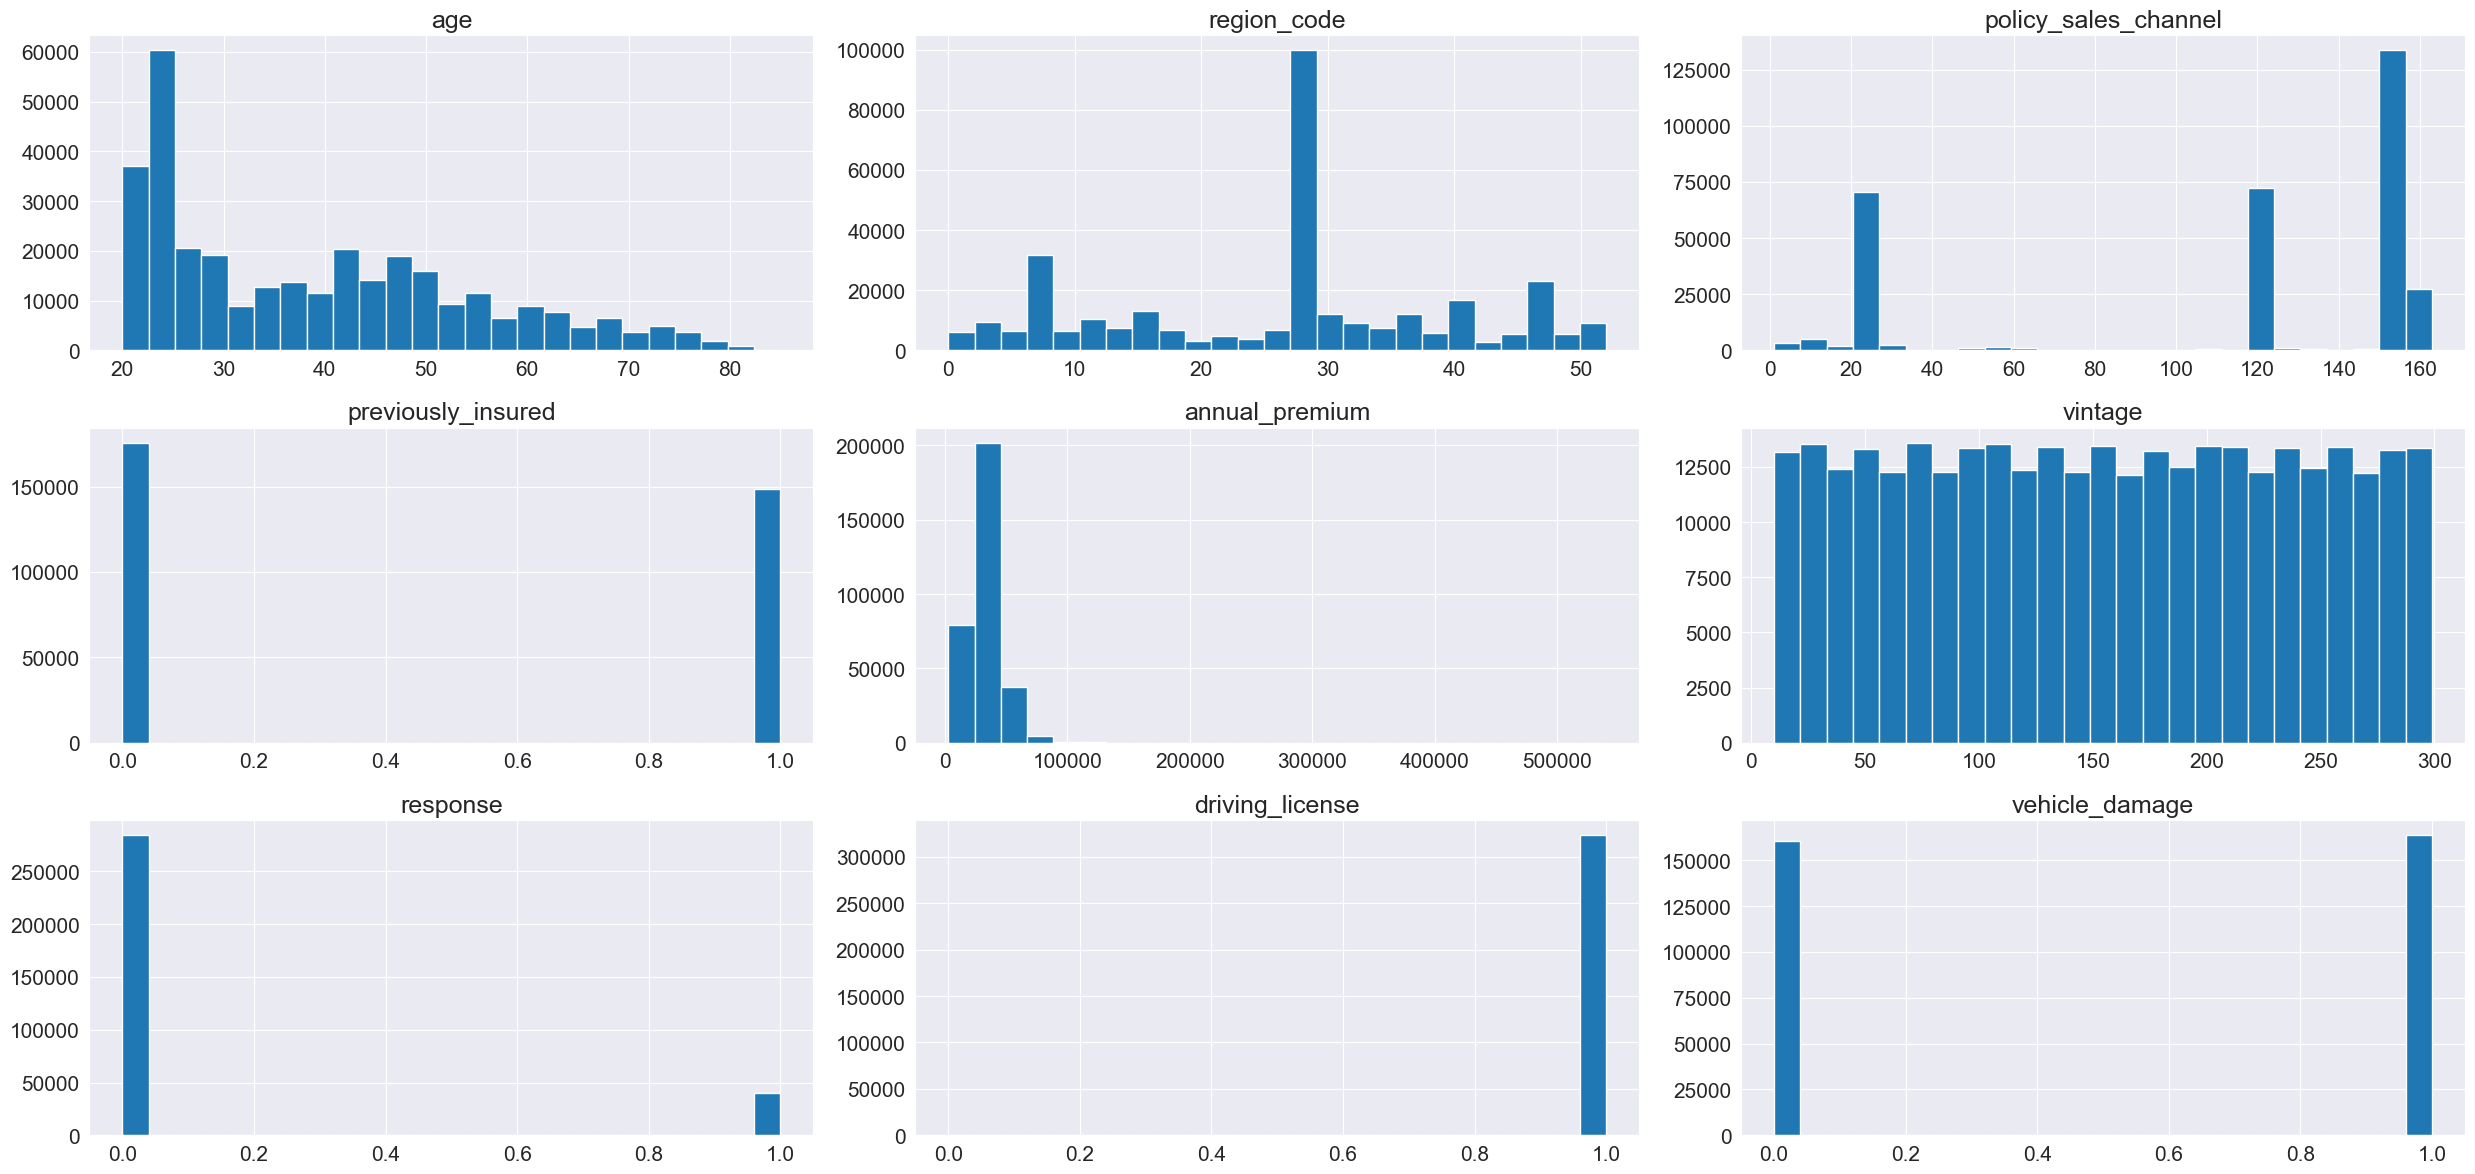

In [16]:
plt.figure(figsize=(30, 15))
df3.select_dtypes(include=['float64', 'int64']).drop('id', axis=1).hist(bins=25);

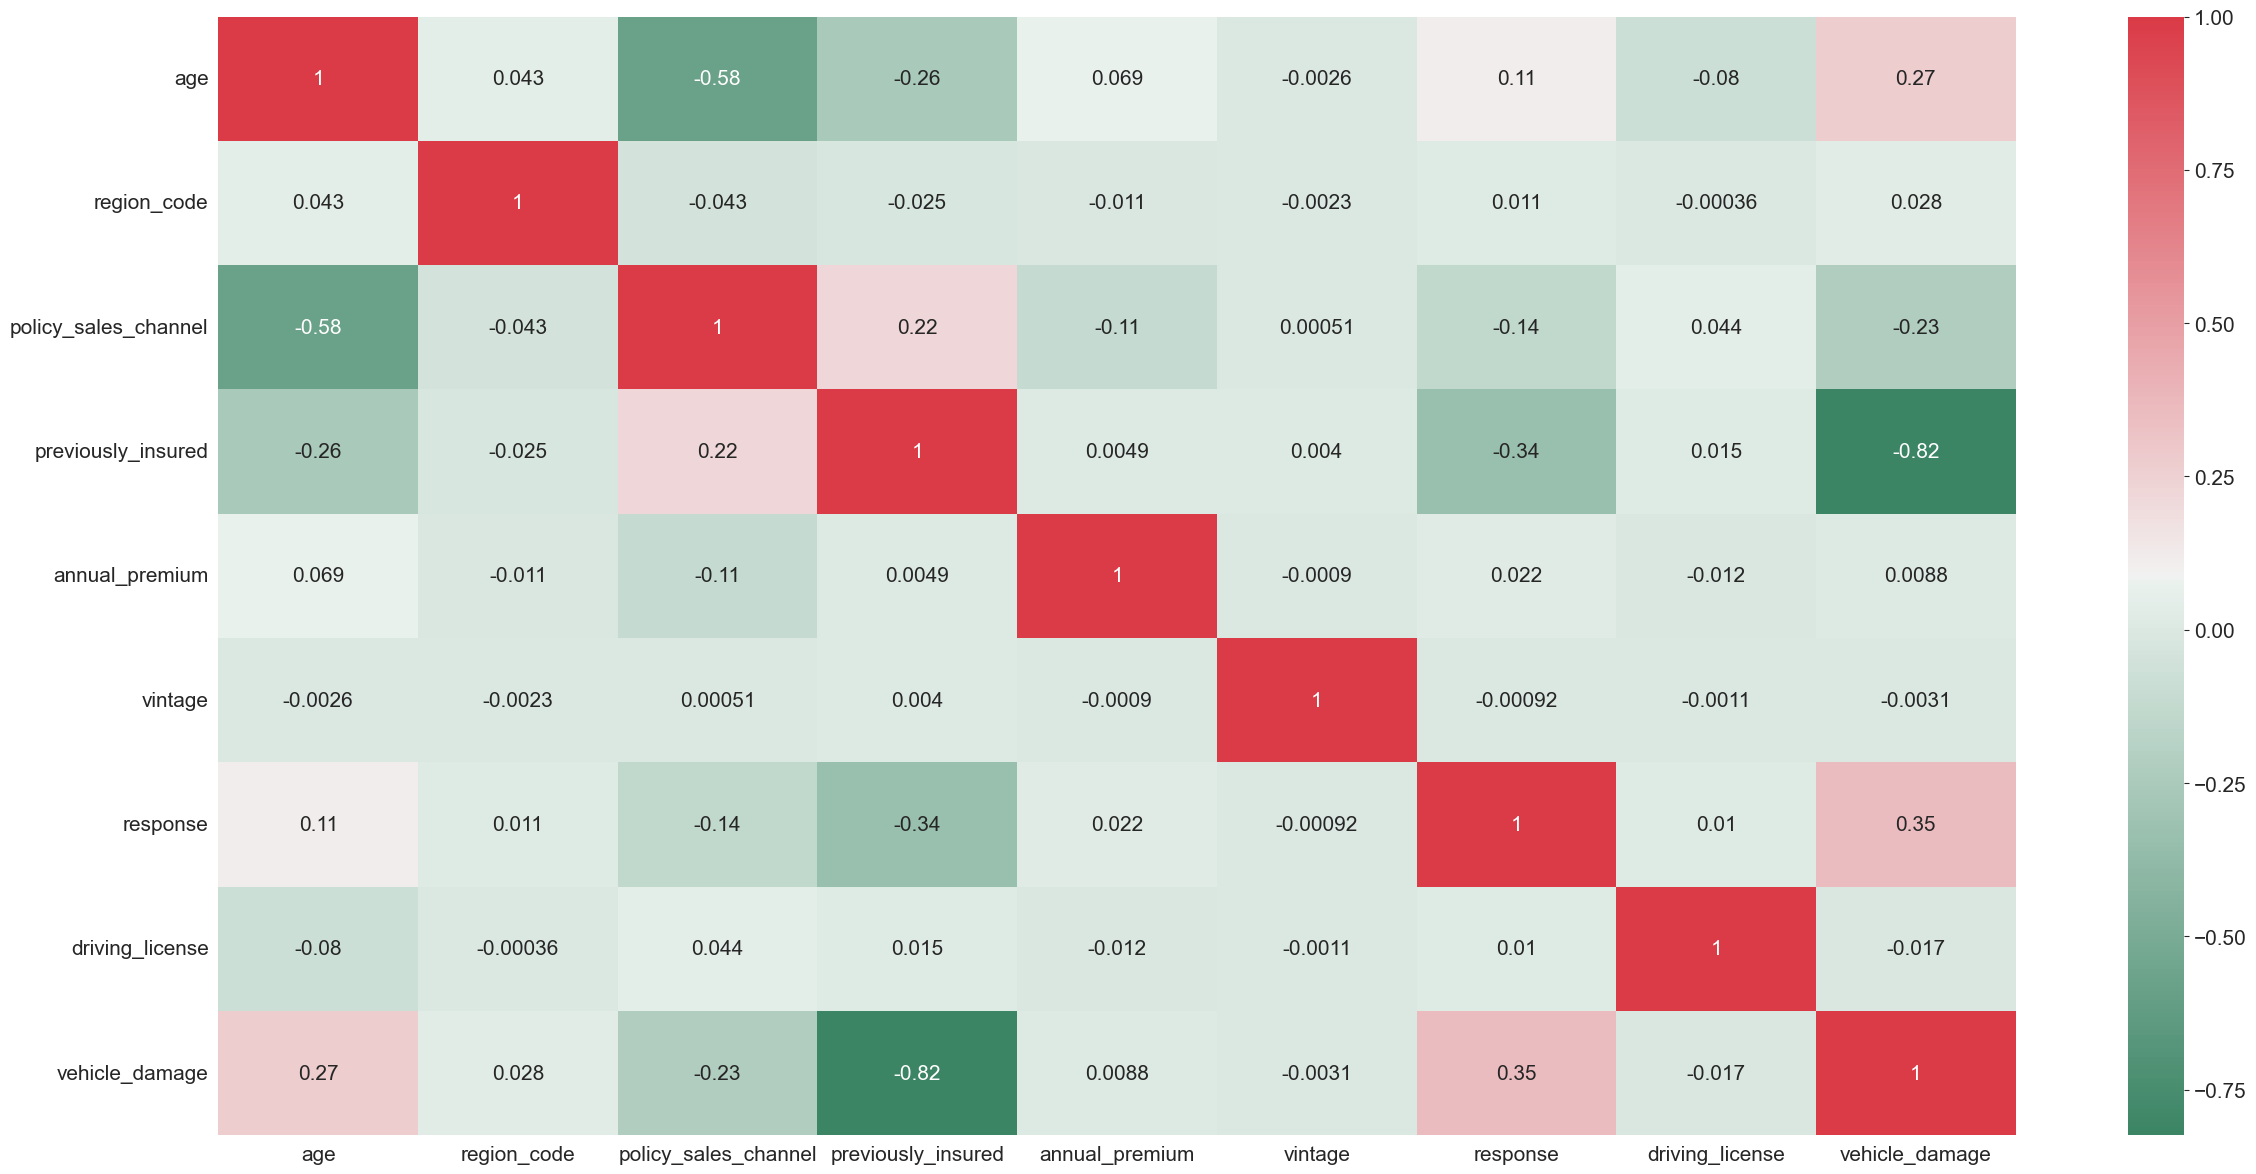

In [17]:
corr = df3.drop('id', axis=1).corr(numeric_only=True)
cmap = sns.diverging_palette(150, 10, as_cmap=True)

sns.heatmap(corr, annot=True, cmap=cmap,);

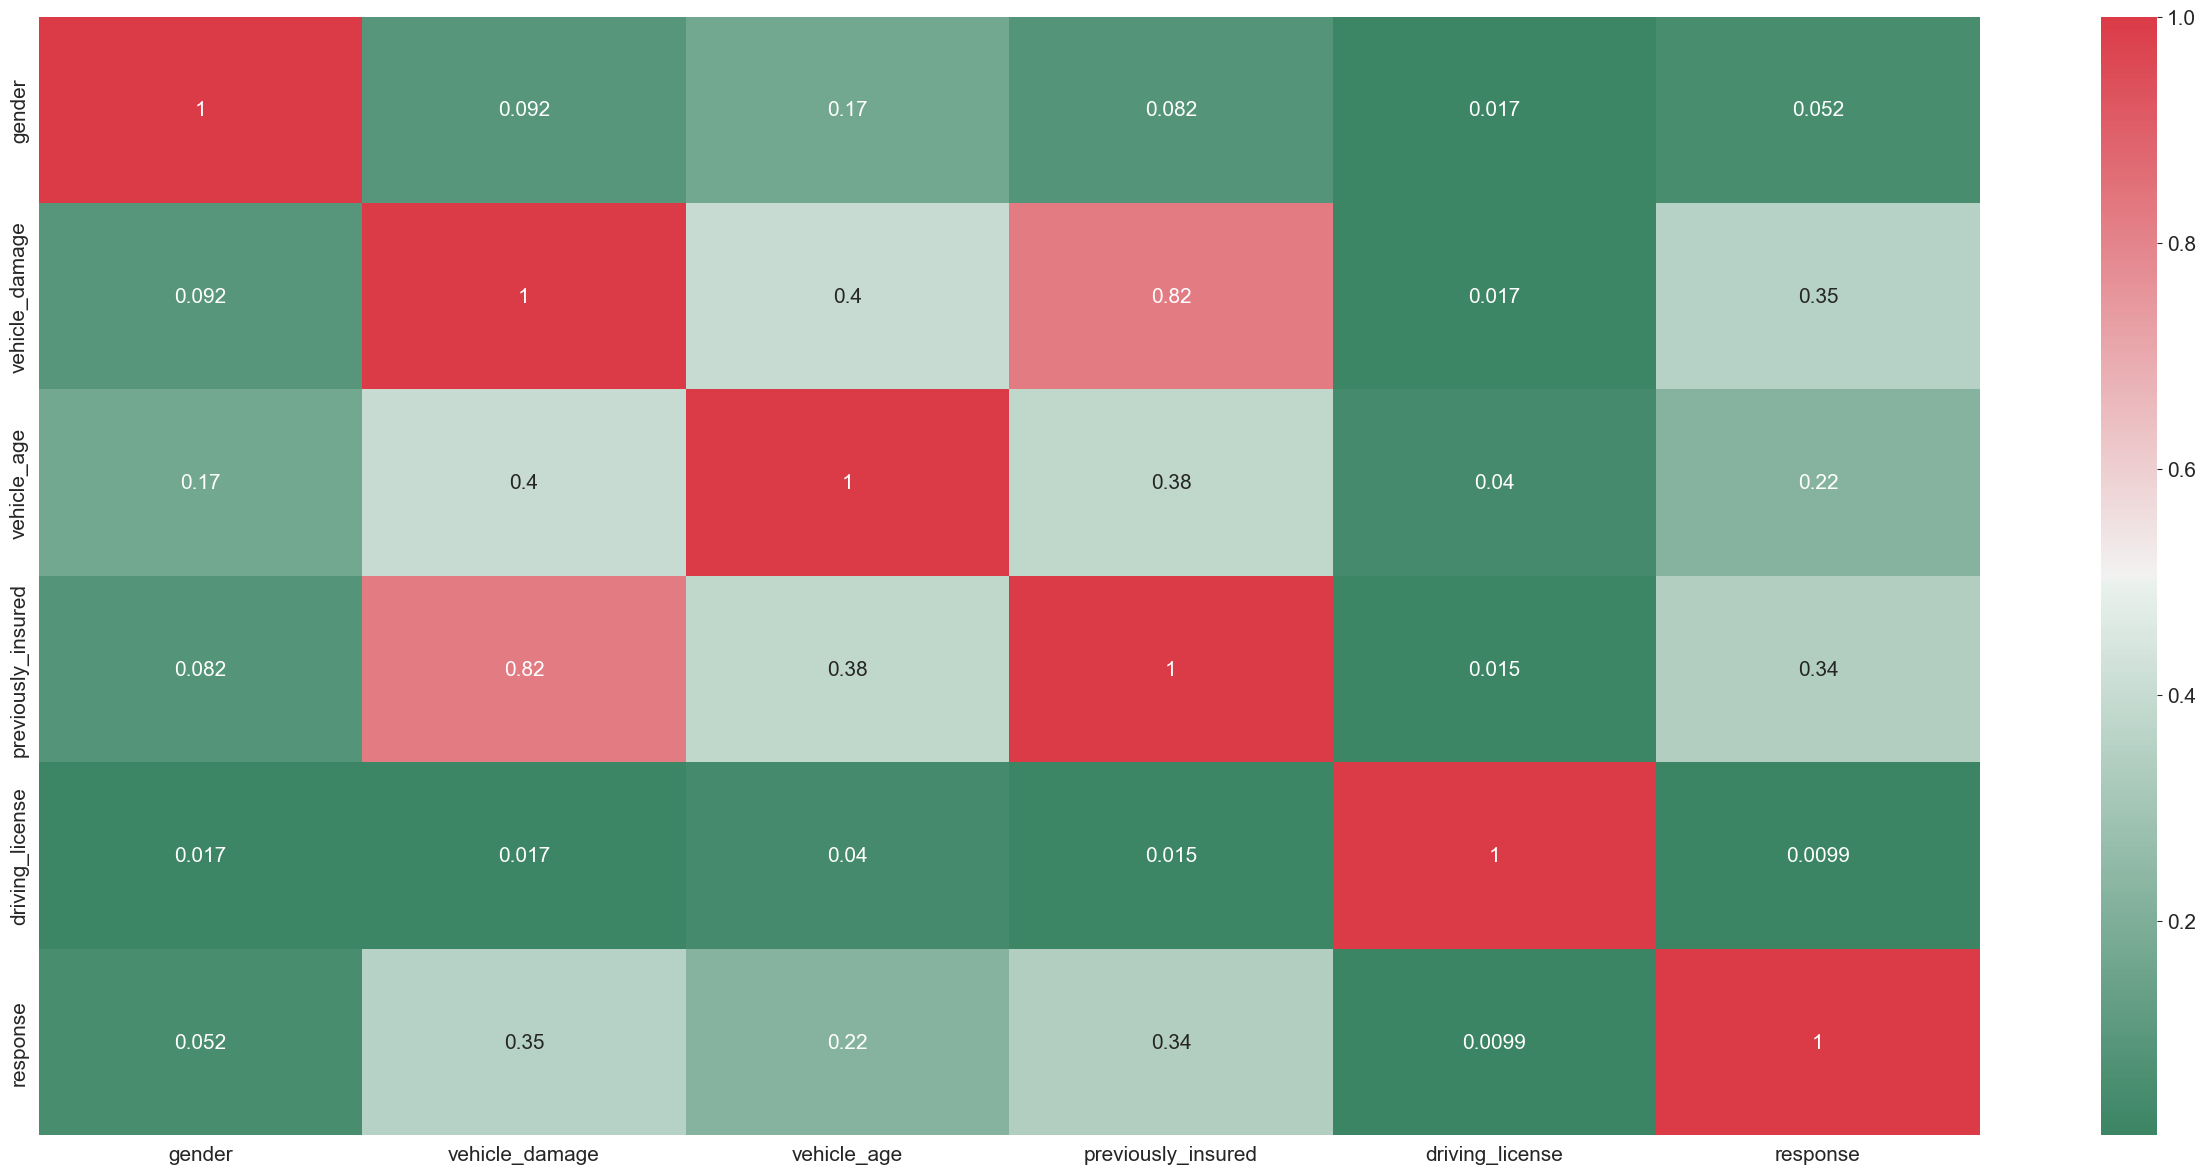

In [19]:
dic = {}
lis = []
for att in ['gender', 'vehicle_damage', 'vehicle_age', 'previously_insured', 'driving_license', 'response']:
    for att_2 in ['gender', 'vehicle_damage', 'vehicle_age', 'previously_insured', 'driving_license', 'response']:
        a = hf.cramer_v(df3[att], df3[att_2])
        lis.append(a)
    lista = lis.copy()
    dic[att] = lista
    lis.clear()
assoc = pd.DataFrame(dic)
assoc = assoc.set_index(assoc.columns)
sns.heatmap(assoc, cmap=cmap, annot=True);


# 5.0. Data Preparation

In [20]:
df4 = df3.copy()

In [21]:
df_train, df_val = train_test_split(df4, test_size=0.17647, stratify=df4['response'], random_state=42)

In [22]:
# Cross-validation data
X_train_cv = df4.drop(['id', 'response'], axis=1)
y_train_cv = df4['response'].copy()

# Train data
X_train = df_train.drop(['id', 'response'], axis=1)
y_train = df_train['response'].copy()

# Validation set
X_val = df_val.drop(['id', 'response'], axis=1)
y_val = df_val['response'].copy()

# Unseen data (test)
X_test = test.drop(['id', 'response'], axis=1)
y_test = test['response'].copy()

In [23]:
# Applying the same transformations to the  tes set.
X_test['vehicle_age'] = X_test['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x== '1-2 Year' else 'under_1_year')

X_test['vehicle_damage'] = X_test['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [24]:
X_train.shape

(266775, 10)

In [25]:
X_val.shape

(57167, 10)

## 5.1 Pipeline for data preparation and model training.

Robust Scaler
 - Annual Premium

MinMaxScaler
 - Age

Frequency Encoder
 - Region Code
 - Policy Sales Channel
 - vehicle_age

In [26]:
# OneHot Encoding
onehot = OneHotEncoder()
oneh_cols = ['gender', 'vehicle_damage', 'vehicle_age']
oh_transformmer = Pipeline([('onehot_enc', onehot)])

# Robust Scaler
robust_sc = RobustScaler()
robust_cols = ['annual_premium']
rob_transformer = Pipeline([('robust_sc', robust_sc)])

# MinMax Scaler
minmax_sc = MinMaxScaler()
minmax_cols = ['age', 'vintage']
minmax_transformer = Pipeline([('minmax_sc', minmax_sc)])

# Frequency Encoder
freq_enc = enc.CountFrequencyEncoder(encoding_method='frequency', ignore_format=True, unseen='encode')
freq_cols = ['region_code', 'policy_sales_channel']
freq_transformer = Pipeline([('frequency_enc', freq_enc)])

preprocess_scaling = ColumnTransformer(transformers=[('onehot', oh_transformmer, oneh_cols),
                                ('robust_scaler', rob_transformer, robust_cols),
                                ('minmax', minmax_transformer, minmax_cols),
                                ('freq_enconder', freq_transformer, freq_cols),
                                ], remainder='passthrough')


# 6.0 Feature Selection

# 7.0 Machine Learning Models

For this problem, I am interested in ordering the dataset by the propensity of acquiring vehicle insurance, so the usual classification metrics are not ideal here.

## 7.1 Dummy Classifier

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
dummy_clf = DummyClassifier(random_state=42)

pipe_dum = Pipeline(steps=[('preprocess', preprocess_scaling), ('LogisticClassifier', dummy_clf)])
pipe_dum.fit(X_train, y_train)
y_hat_dum = pipe_dum.predict(X_val)
y_prob_dum = pipe_dum.predict_proba(X_val)

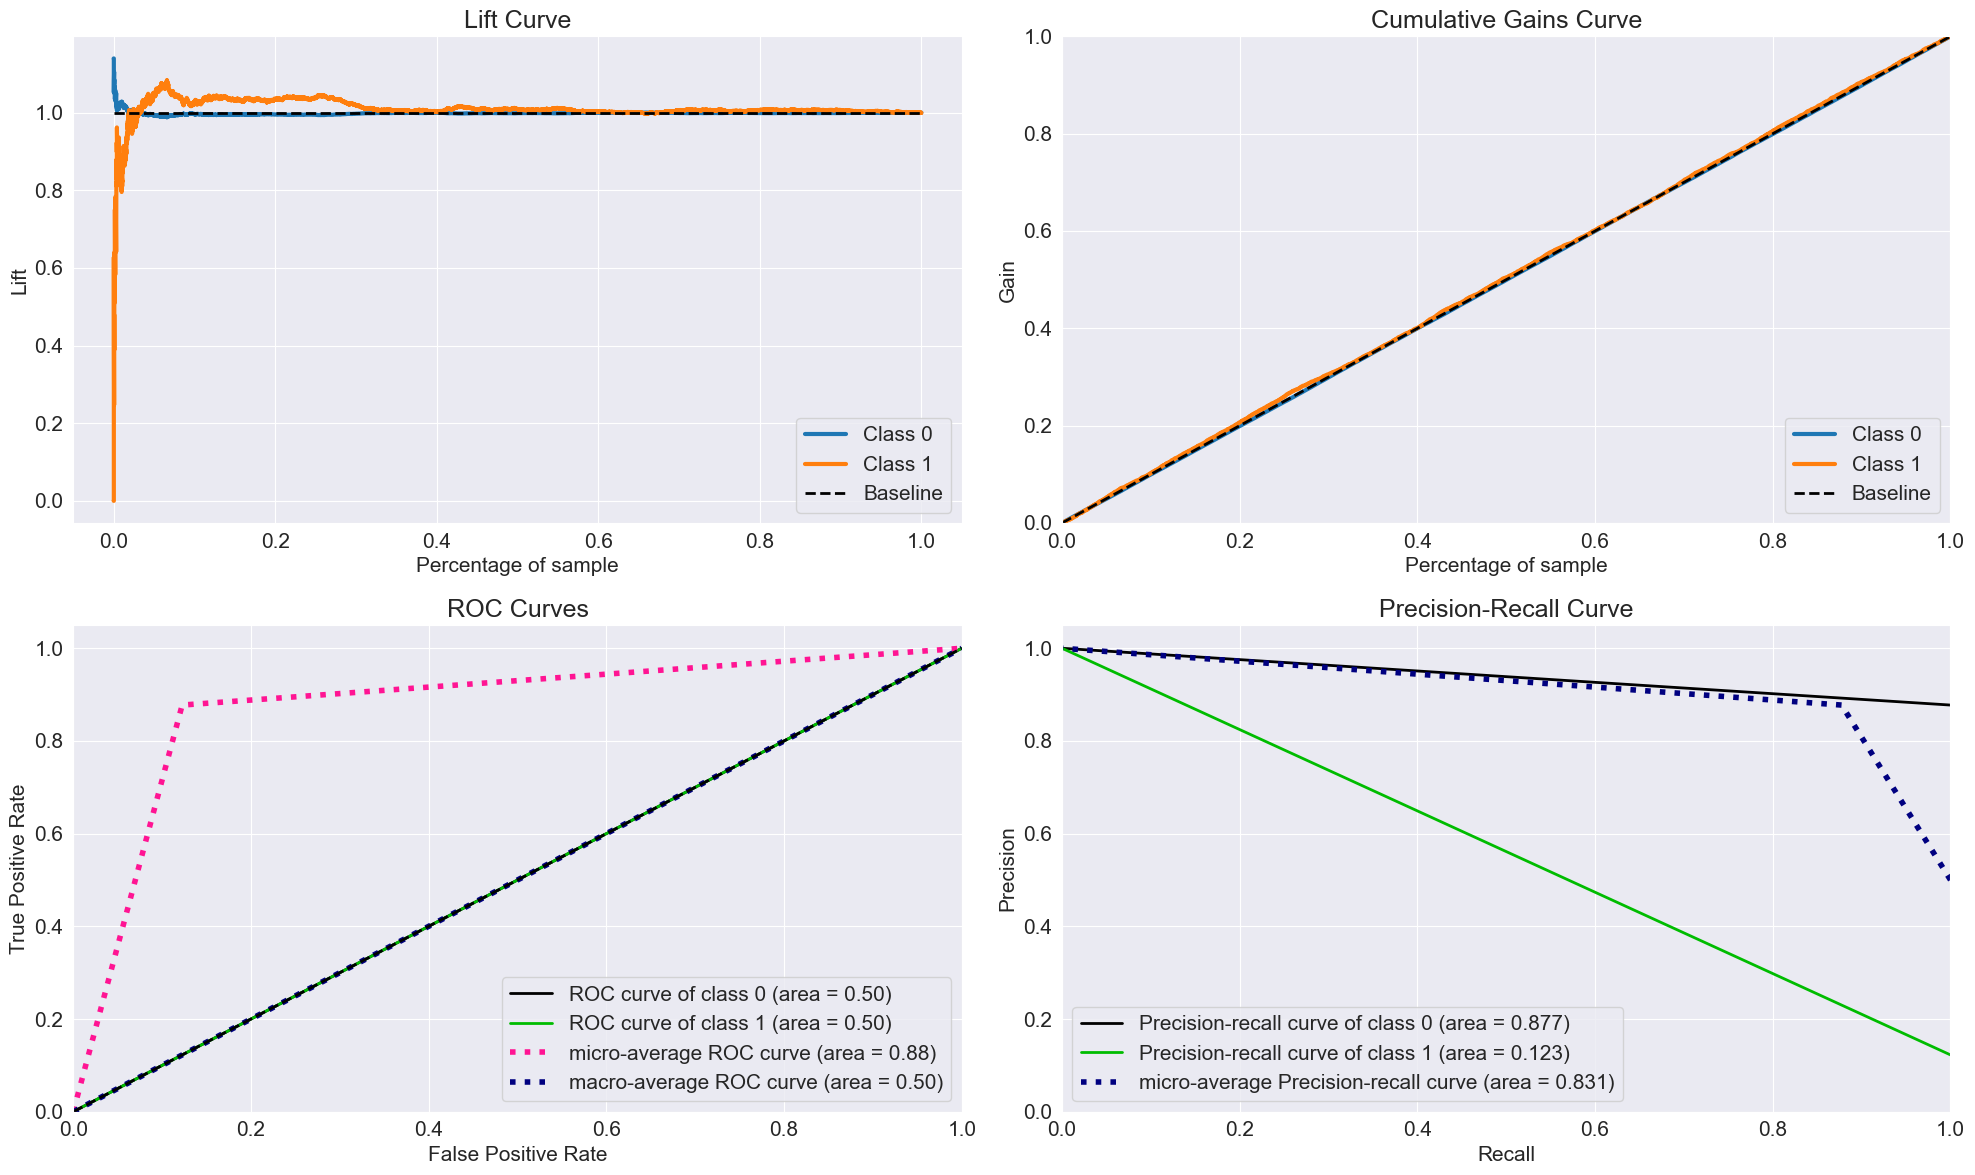

In [29]:
hf.classifier_metrics_plot(y_prob_dum, y_val)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

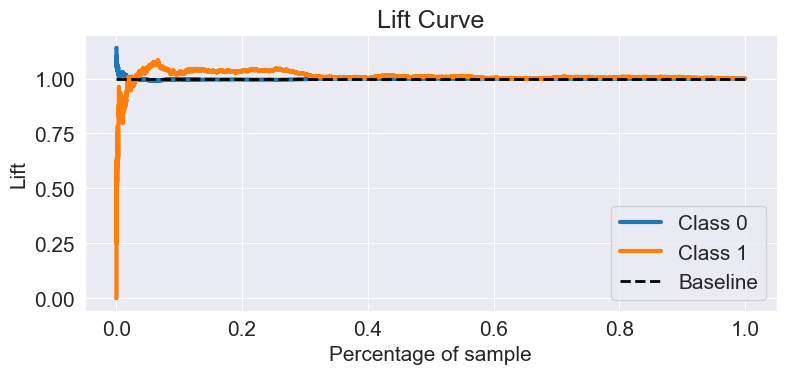

In [30]:
skplt.metrics.plot_lift_curve(y_val, y_prob_dum, figsize=(8, 4))

In [31]:
scores = hf.classifier_metrics_test('DummyClassifier', np.array(y_val), y_hat_dum, y_prob_dum, k=20000)
scores

,balanced_accuracy,f1_score,lift_score,prc_auc,precision,precision_at_20000,recall,recall_at_20000,roc_auc
DummyClassifier,0.5,0.0,NaN,0.561285,0.0,0.123144,0.0,0.351506,0.5


0.5	0.0	NaN	0.561282	0.0	0.125344	0.0	0.268358	0.5

## 7.1 Logistic Regression

In [32]:
lr_clf = LogisticRegressionCV(random_state=0)

pipe = Pipeline(steps=[('preprocess', preprocess_scaling), ('LogisticClassifier', lr_clf,)])
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_val)
y_prob = pipe.predict_proba(X_val)

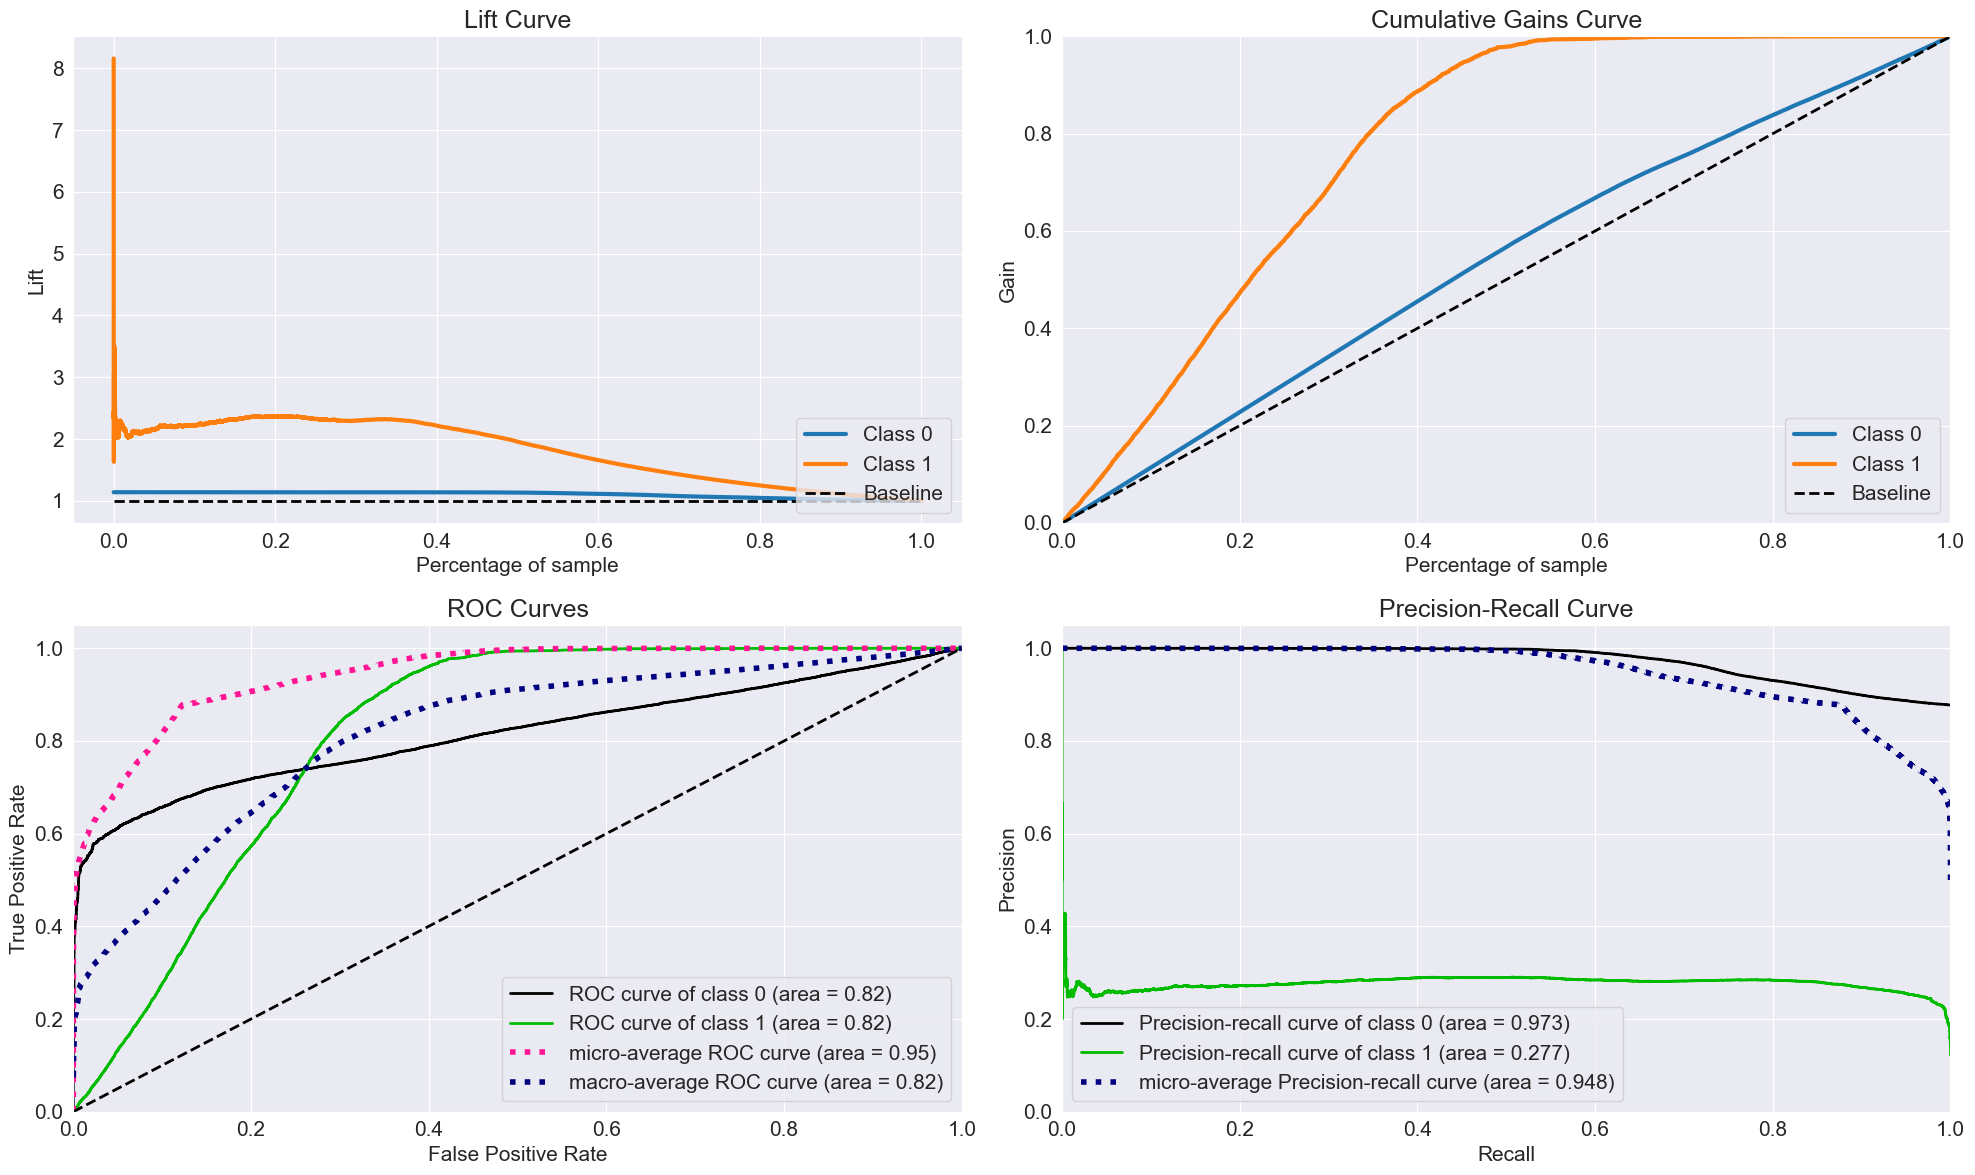

In [33]:
hf.classifier_metrics_plot(y_prob, y_val)

In [34]:
scores = hf.classifier_metrics_test('LogisticRegression', np.array(y_val), y_hat, y_prob, k=20000)
scores

,balanced_accuracy,f1_score,lift_score,prc_auc,precision,precision_at_20000,recall,recall_at_20000,roc_auc
LogisticRegression,0.5,0.0,NaN,0.276559,0.0,0.283186,0.0,0.808335,0.815598


In [35]:
knn_clf = KNeighborsClassifier(n_neighbors=7, metric='minkowski', p=2, n_jobs=-1)

pipe_knn = Pipeline(steps=[('preprocess', preprocess_scaling), ('KNeighboors', knn_clf)])
pipe_knn.fit(X_train, y_train)

y_hat_knn = pipe_knn.predict(X_val)
y_prob_knn = pipe_knn.predict_proba(X_val)

## 7.2 KNeighboors

In [36]:
knn_clf = KNeighborsClassifier(n_neighbors=7, metric='minkowski', p=2, n_jobs=-1)

pipe_knn = Pipeline(steps=[('preprocess', preprocess_scaling), ('KNeighboors', knn_clf)])
pipe_knn.fit(X_train, y_train)

y_hat_knn = pipe_knn.predict(X_val)
y_prob_knn = pipe_knn.predict_proba(X_val)

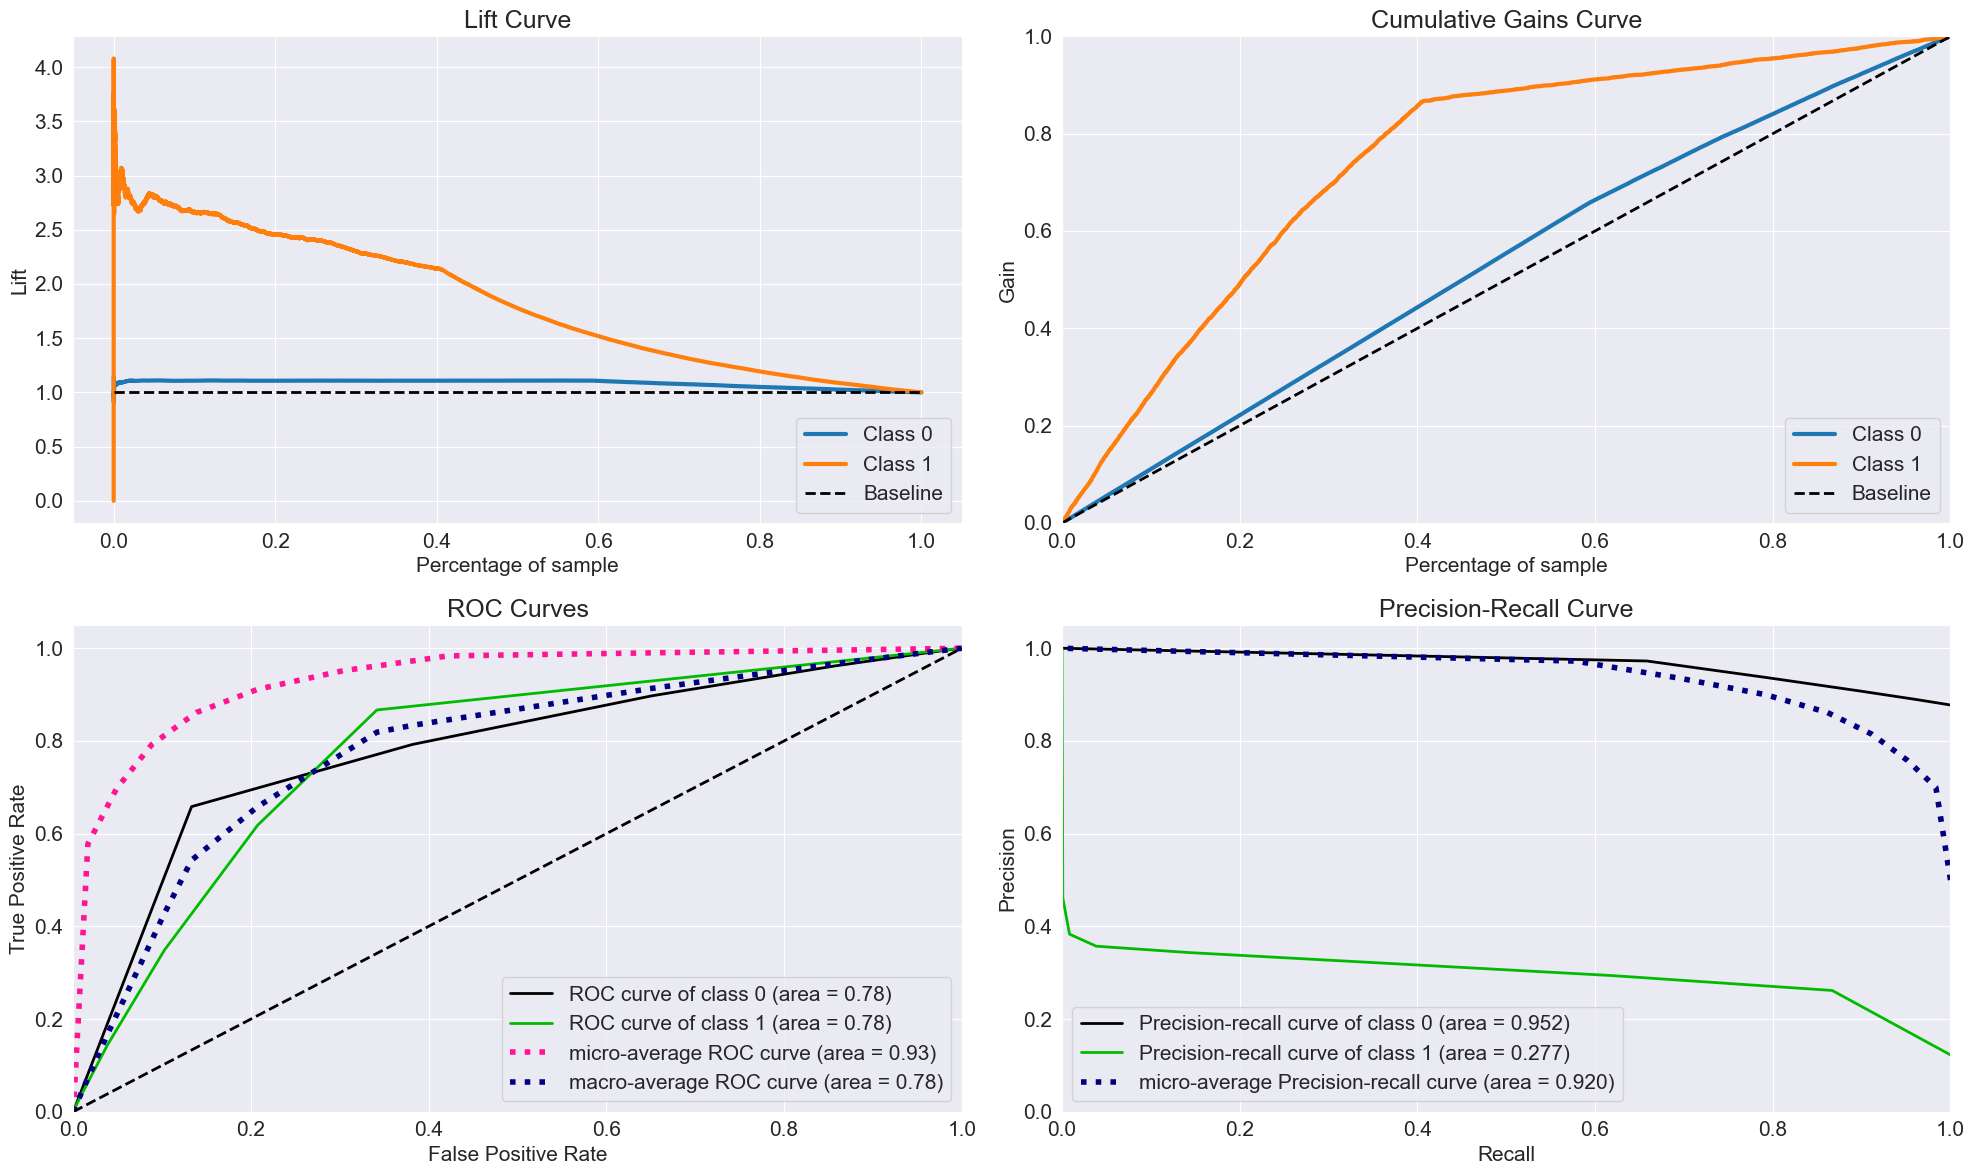

In [37]:
hf.classifier_metrics_plot(y_prob_knn, y_val)

In [38]:
hf.classifier_metrics_test('KNeighboors', y_val, y_hat_knn, y_prob_knn, k=20000)

,balanced_accuracy,f1_score,lift_score,prc_auc,precision,precision_at_20000,recall,recall_at_20000,roc_auc
KNeighboors,0.552504,0.202195,2.801365,0.297611,0.343365,0.271236,0.143285,0.774226,0.78344


## 7.3 LightGBM 

In [39]:
lgbm_clf = LGBMClassifier(random_state=0)

pipe_lgbm = Pipeline(steps=[('preprocess', preprocess_scaling), ('LGBMClassifier', lgbm_clf)])
pipe_lgbm.fit(X_train, y_train)

y_hat_lgbm = pipe_lgbm.predict(X_val)
y_prob_lgbm = pipe_lgbm.predict_proba(X_val)


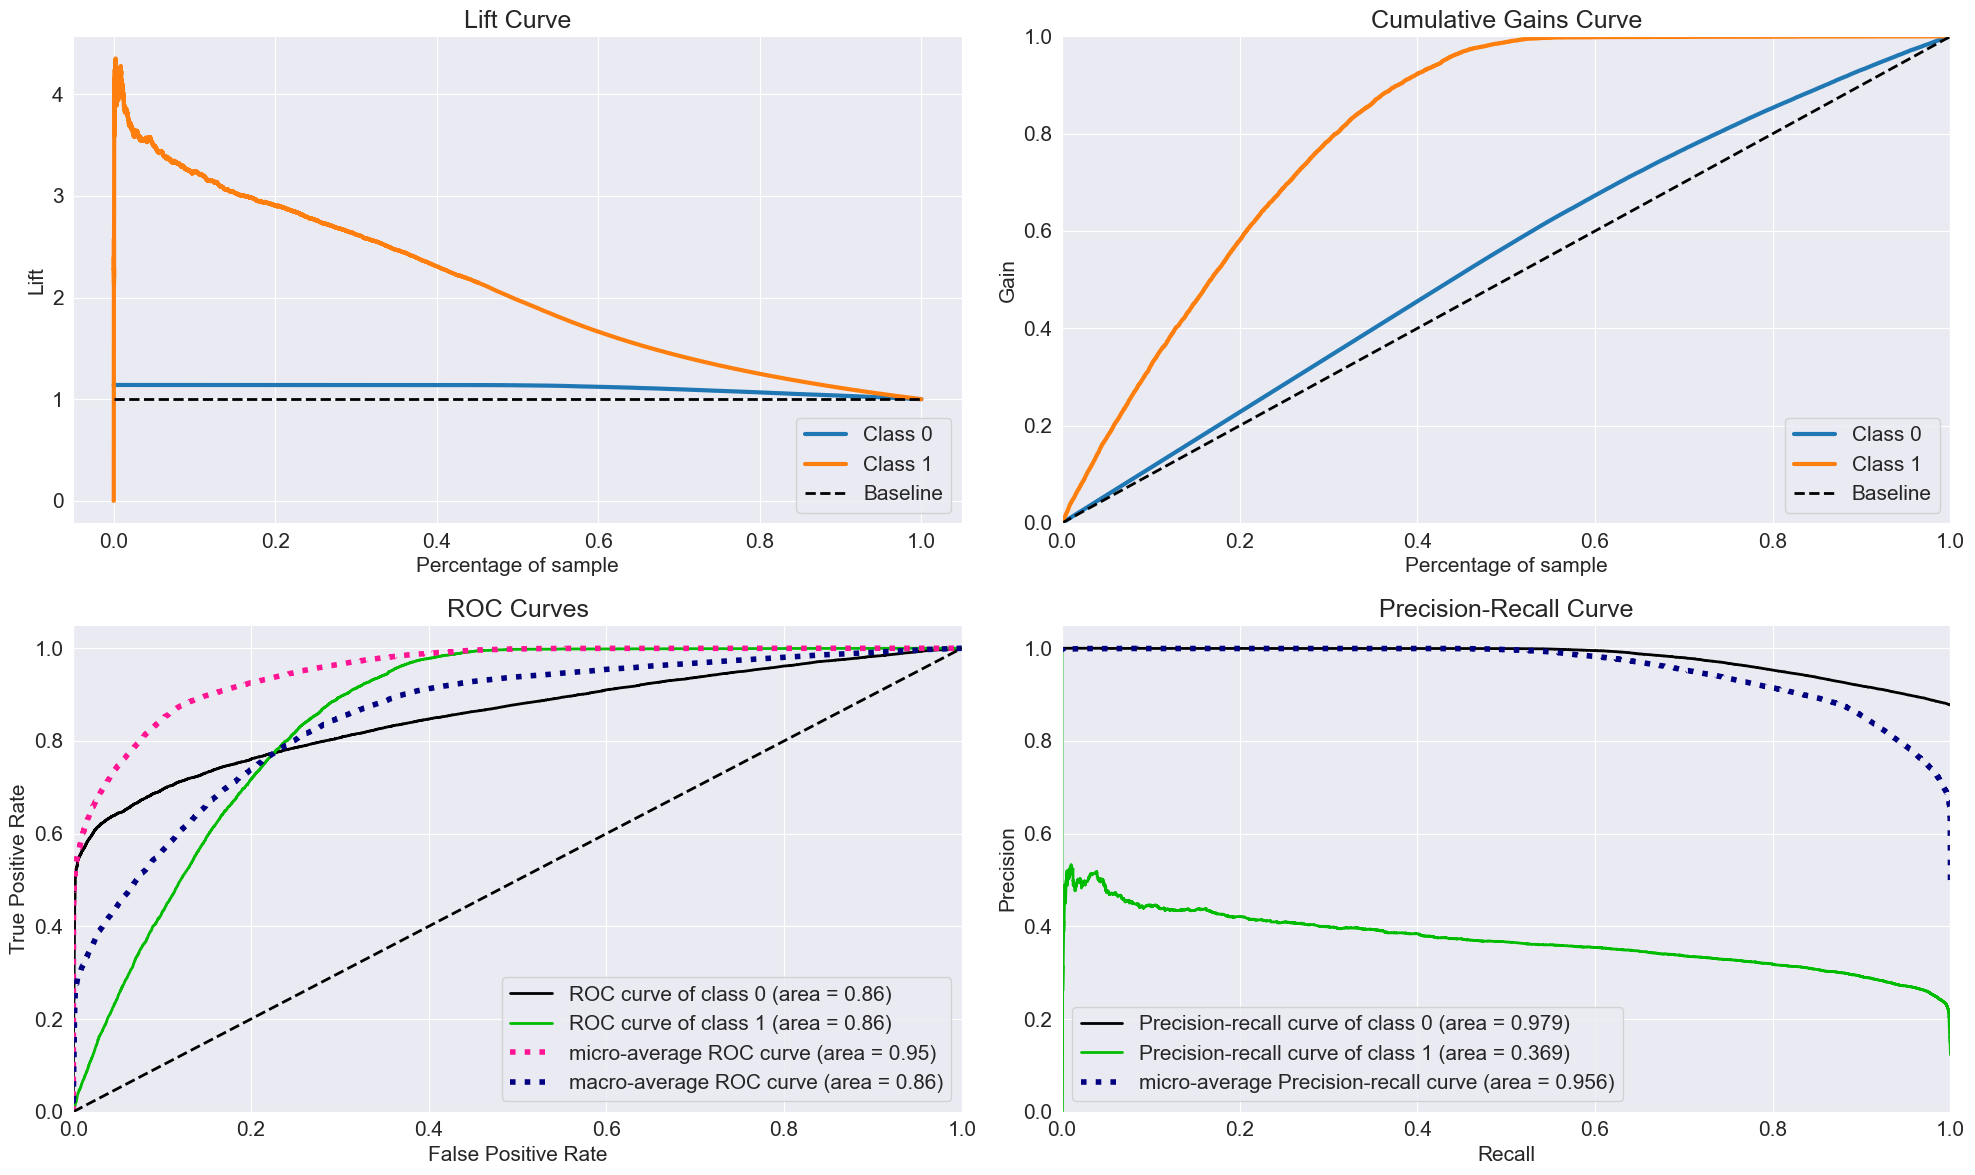

In [40]:
hf.classifier_metrics_plot(y_prob_lgbm, y_val)

In [41]:
hf.classifier_metrics_test('LGBM', y_val, y_hat_lgbm, y_prob_lgbm, k=20000)

,balanced_accuracy,f1_score,lift_score,prc_auc,precision,precision_at_20000,recall,recall_at_20000,roc_auc
LGBM,0.501392,0.00652,3.909308,0.368522,0.479167,0.302585,0.003282,0.863708,0.856735


## 7.4 ExtraTrees

In [42]:
ext_clf = ExtraTreesClassifier(random_state=0)

pipe_ext = Pipeline(steps=[('preprocess', preprocess_scaling), ('ExtraTreesClassifier', ext_clf)])
pipe_ext.fit(X_train, y_train)

y_hat_ext = pipe_ext.predict(X_val)
y_prob_ext = pipe_ext.predict_proba(X_val)

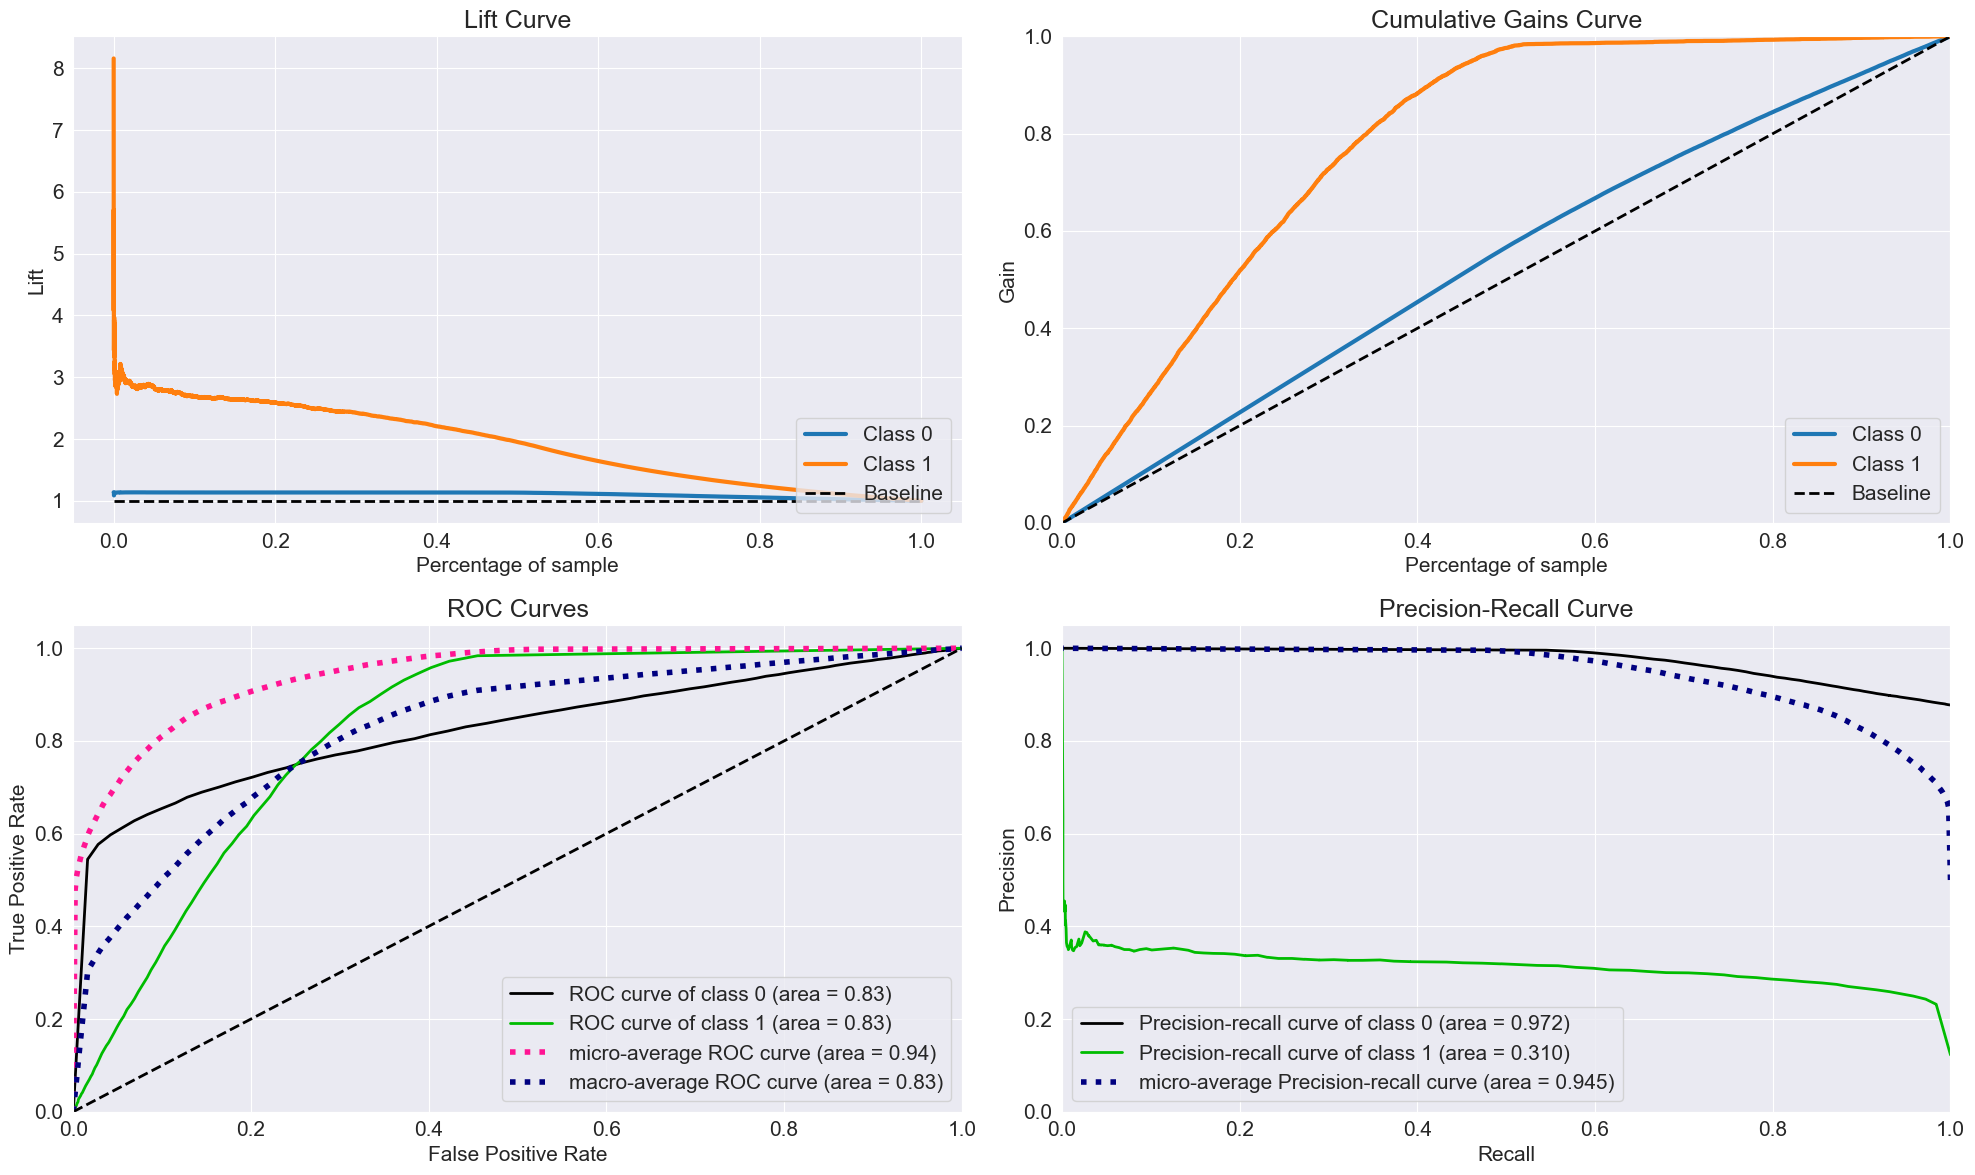

In [43]:
hf.classifier_metrics_plot(y_prob_ext, y_val)


In [44]:
hf.classifier_metrics_test('ExtraTrees', y_val, y_hat_ext, y_prob_ext, k=20000)

,balanced_accuracy,f1_score,lift_score,prc_auc,precision,precision_at_20000,recall,recall_at_20000,roc_auc
ExtraTrees,0.552501,0.201906,2.842225,0.312205,0.348374,0.284686,0.142144,0.812616,0.82629


## 7.5 GaussianNB

In [45]:
gau_clf = GaussianNB()

pipe_gau = Pipeline(steps=[('preprocess', preprocess_scaling), ('GaussianClassifier', gau_clf)])
pipe_gau.fit(X_train, y_train)

y_hat_gau = pipe_gau.predict(X_val)
y_prob_gau = pipe_gau.predict_proba(X_val)

In [46]:
y_pred_gau = (pipe_gau.predict_proba(X_val)[:, 1] > 0.2).astype(float)

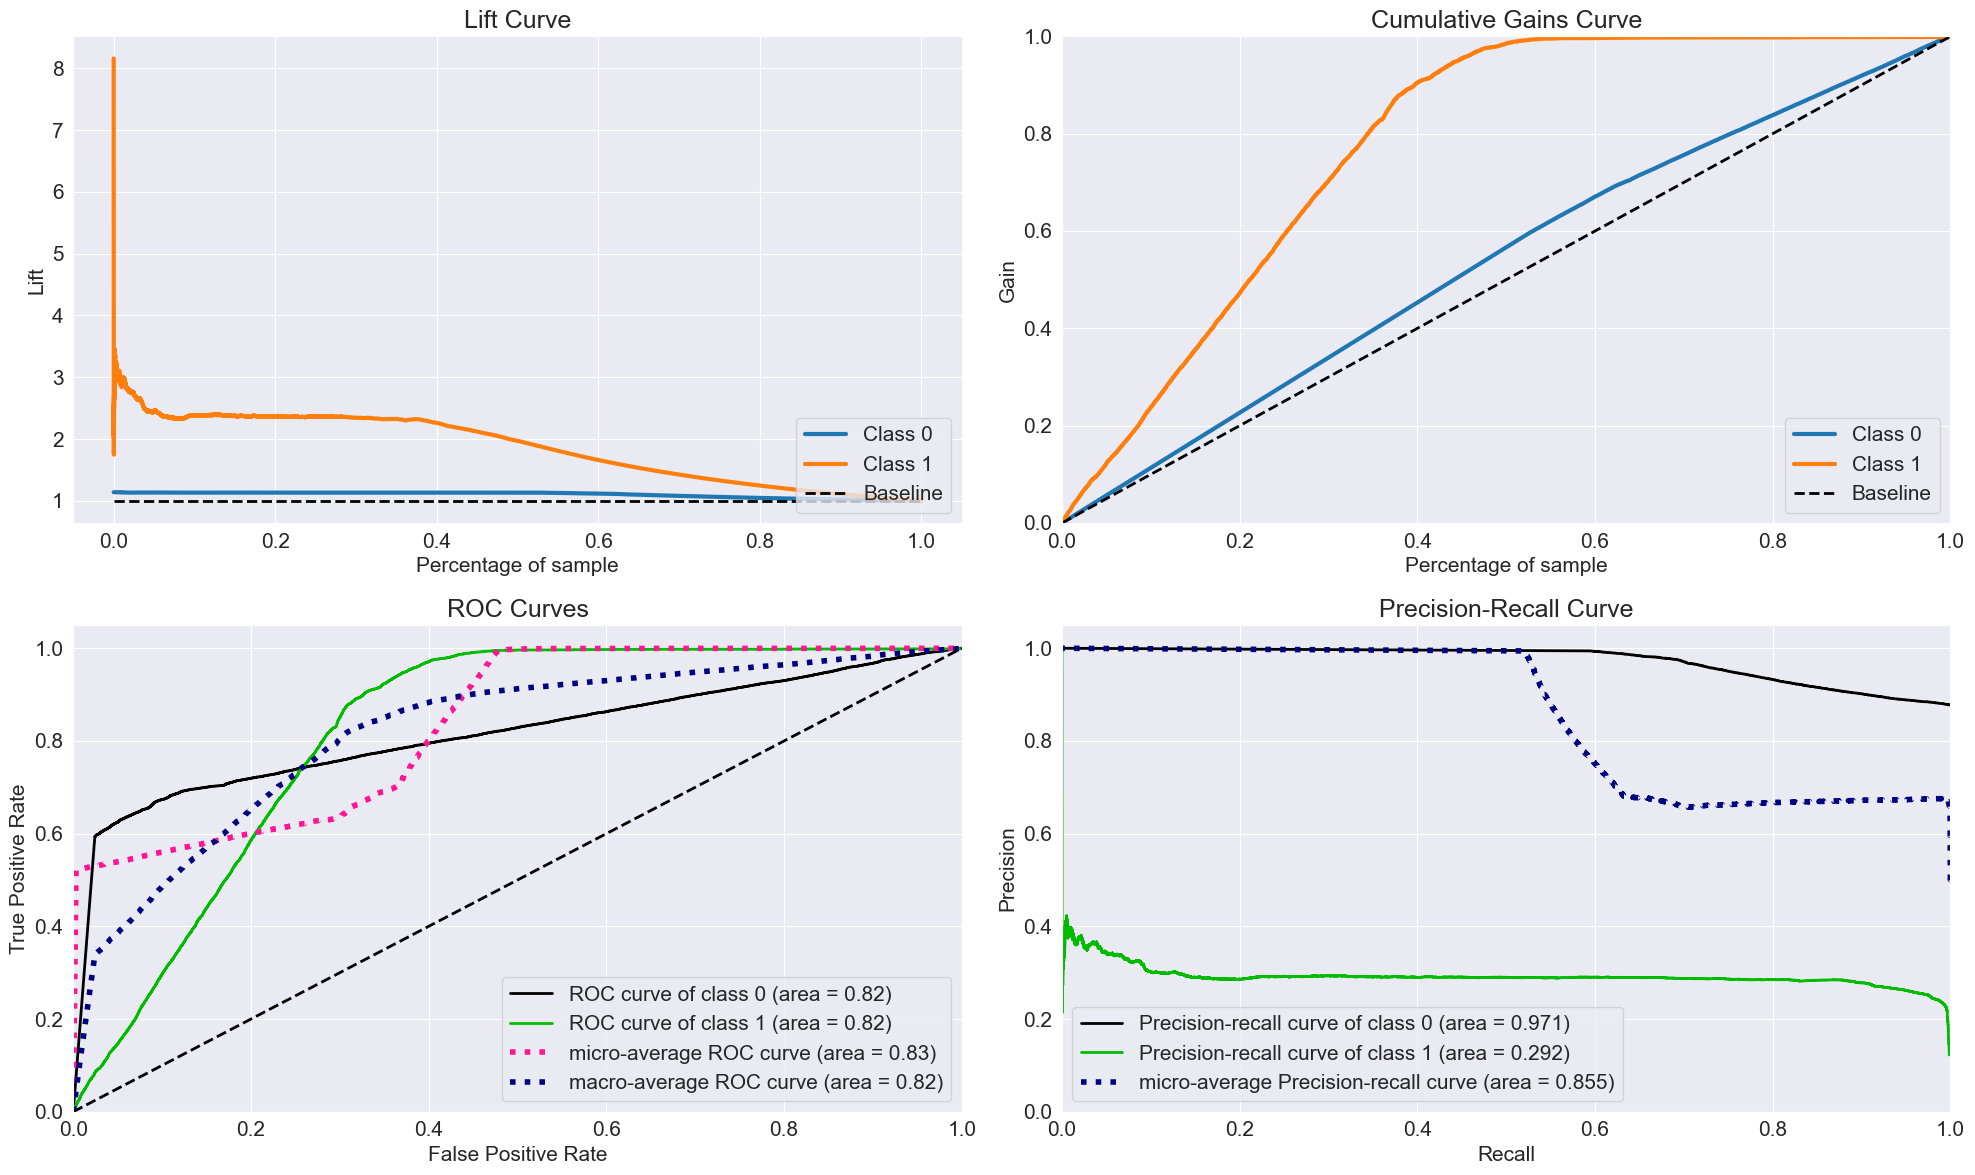

In [47]:
hf.classifier_metrics_plot(y_prob_gau, y_val)


In [48]:
hf.classifier_metrics_test('Gaussian', np.array(y_val), y_hat_gau, y_prob_gau, k=20000)

,balanced_accuracy,f1_score,lift_score,prc_auc,precision,precision_at_20000,recall,recall_at_20000,roc_auc
Gaussian,0.78819,0.413032,2.157562,0.291535,0.264454,0.284736,0.942629,0.812759,0.820835


In [49]:
weight = y_train.value_counts()[0]/y_train.value_counts()[1]
extra_dict = {
            'LogisticRegression': LogisticRegressionCV(random_state=42, n_jobs=-1),
            'LGBM': LGBMClassifier(random_state=0, n_jobs=-1),
            'KNN': KNeighborsClassifier(n_neighbors=7, metric='minkowski', p=2, n_jobs=-1),
            'ExtraTrees': ExtraTreesClassifier(random_state=0, n_jobs=-1),
            'Gaussian': GaussianNB(),
            }
scores = pd.DataFrame()

for name, classifier in extra_dict.items():
     
    pipe = Pipeline(steps=[('preprocess', preprocess_scaling), (name, classifier)])

    score = cross_validate(pipe, X_train, y_train, cv=10, scoring=['recall', 'roc_auc', 'precision', 'balanced_accuracy', 'f1'])
    scores = pd.concat([scores, hf.scores_summary(score, name)])
    
scores

,fit_time,score_time,test_recall,test_roc_auc,test_precision,test_balanced_accuracy,test_f1
LogisticRegression,6.0528 +/- 1.5642,0.0677 +/- 0.0059,0.0 +/- 0.0,0.8169 +/- 0.0142,0.0 +/- 0.0,0.5 +/- 0.0,0.0 +/- 0.0
LGBM,0.8465 +/- 0.1249,0.1106 +/- 0.0146,0.0043 +/- 0.0028,0.856 +/- 0.0051,0.4161 +/- 0.2175,0.5017 +/- 0.0014,0.0085 +/- 0.0055
KNN,1.618 +/- 0.1028,3.7561 +/- 0.4355,0.1359 +/- 0.0065,0.7824 +/- 0.0072,0.3336 +/- 0.0246,0.549 +/- 0.0041,0.1931 +/- 0.01
ExtraTrees,5.6348 +/- 0.3048,0.3574 +/- 0.0338,0.1392 +/- 0.008,0.8256 +/- 0.0051,0.3441 +/- 0.0211,0.551 +/- 0.0044,0.1982 +/- 0.0109
Gaussian,0.2882 +/- 0.018,0.0866 +/- 0.0065,0.9425 +/- 0.0073,0.8203 +/- 0.0077,0.2637 +/- 0.0049,0.7874 +/- 0.0043,0.4121 +/- 0.0058


Since our data is heavily imbalanced, we have very poor metrics except for roc_auc which can be misleading. Because, for imbalanced classification with a severe skew and few examples of the minority class, a small number of correct or incorrect predictions can result in a large change in the ROC AUC score.

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/